## Text Detection Inference Example

In [1]:
%load_ext autoreload
%autoreload 2

# args
box_type = 'quad' # quad or poly

### Read image path(s)

In [5]:
import os
import glob 

def get_image_paths(data_dir):
    fmts = ['jpg', 'png', 'jpeg']
    img_paths = []
    if os.path.isfile(data_dir):
        img_paths.append(data_dir)
    else:
        for fmt in fmts:
            img_paths.extend(glob.glob(os.path.join(data_dir, f'*.{fmt}')))
            img_paths.extend(glob.glob(os.path.join(data_dir, f'*.{fmt.upper()}')))
    
    return sorted(img_paths)

#data_dir = '/Users/Samit/Data/datasets/ic15/det/test/ch4_test_images'
#data_dir = '/Users/Samit/Data/datasets/MSRA-TD500/test'
#data_dir = '/Users/Samit/Data/datasets/my_test/doc_paper.png'
data_dir = '/Users/Samit/Data/datasets/CTW1500/test_images/1019.jpg'
img_paths = get_image_paths(data_dir)
len(img_paths)

1

TODO: Supplment pretrained model

### Preprocess

In [6]:
from mindocr.data.transforms import create_transforms, run_transforms
from mindocr.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import cv2

class Preprocessor(object):
    def __init__(self, task='det', algo='db'):
        if task == 'det':
            pipeline = [
                {'DecodeImage': 
                     {'img_mode': 'RGB',
                      'keep_ori': True,
                      'to_float32': False}},
                #{'ScalePadImage': 
                #     {'target_size': [1152, 2048]}},
                #{'DetResizeForInfer': 
                #     {'target_size': [1152, 2048],
                #      'keep_ratio': True,
                #      'limit_type': 'auto',
                #      'padding': True,
                #      'force_divisable': False
                #     }},
                {'DetResize': 
                     {'target_size': [1152, 2048],
                      'keep_ratio': True,
                      'target_limit_side': 960, #736,
                      'limit_type': 'min',
                      'padding': False,
                      'force_divisable': False # TODO: dbnet don't need it?
                     }},
                {'NormalizeImage': 
                     {'bgr_to_rgb': False,
                    'is_hwc': True,
                    'mean': IMAGENET_DEFAULT_MEAN,
                    'std': IMAGENET_DEFAULT_STD}},
                {'ToCHWImage': None}]
        elif task == 'rec':
            pipeline = [
                {'DecodeImage': 
                     {'img_mode': 'RGB',
                      'keep_ori': True,
                      'to_float32': False}},
                {'RecResizeForInfer':   # TODO: test for different args
                     {'target_height': 32, 
                      'target_width': 120, 
                      'keep_ratio': True,
                      'padding': False,
                      #'interpolation': cv2.INTER_CUBIC
                     }
                    
                },
                #{'RecResizeImg': 
                #     {'image_shape': [32, 100], # TODO: it should not be fixed, select the optimal width
                #      'infer_mode': True, 'character_dict_path': None,
                #      'padding': True, # TODO: ppocr set True. Test 
                #     }},
                {'NormalizeImage': 
                     {'bgr_to_rgb': False,
                    'is_hwc': True,
                    'mean': [127.0, 127.0, 127.0],
                    'std': [127.0, 127.0, 127.0]}},
                {'ToCHWImage': None}]
        self.pipeline = pipeline
        self.transforms = create_transforms(pipeline)
    
    def __call__(self, img_or_path):
        if isinstance(img_or_path, str):
            data = {'img_path': img_or_path}
            output = run_transforms(data, self.transforms)
        else:
            data = {'image': img_or_path}
            data['image_ori'] = img_or_path.copy() # TODO
            data['image_shape'] = img_or_path.shape
            output = run_transforms(data, self.transforms[1:])
            
        
        return output

In [7]:
preproc = Preprocessor()

data = preproc(img_paths[0])
data

{'img_path': '/Users/Samit/Data/datasets/CTW1500/test_images/1019.jpg',
 'image': array([[[ 0.99880123,  0.91317743,  0.57068235, ...,  1.5467933 ,
           1.5639181 ,  1.5810429 ],
         [ 0.89605266,  0.8275537 ,  0.4850586 , ...,  1.495419  ,
           1.5296686 ,  1.5296686 ],
         [ 0.4508091 ,  0.38231006,  0.07406451, ...,  1.2727972 ,
           1.3070468 ,  1.3241715 ],
         ...,
         [ 1.7522904 ,  1.700916  ,  1.5125438 , ...,  1.0330507 ,
           1.084425  ,  1.1015497 ],
         [ 1.7522904 ,  1.700916  ,  1.42692   , ...,  1.0501754 ,
           1.084425  ,  1.1015497 ],
         [ 1.7522904 ,  1.6837914 ,  1.4097953 , ...,  1.0501754 ,
           1.084425  ,  1.1015497 ]],
 
        [[ 1.1330533 ,  1.0455183 ,  0.67787117, ...,  1.0630252 ,
           1.0980393 ,  1.1155462 ],
         [ 1.0280112 ,  0.95798326,  0.59033614, ...,  1.0280112 ,
           1.0630252 ,  1.0630252 ],
         [ 0.60784316,  0.53781515,  0.2051821 , ...,  0.8004202 ,
   

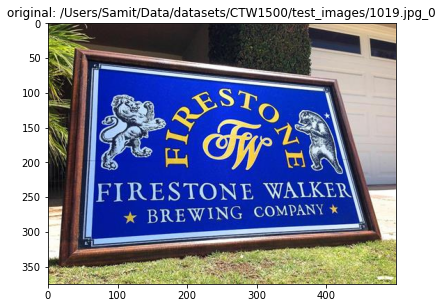

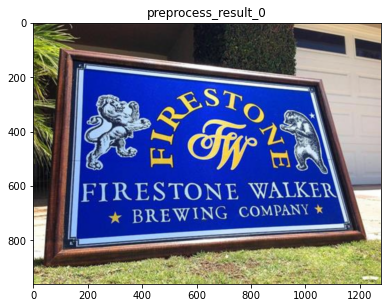

(375, 500, 3)
(3, 960, 1280)


In [8]:
from mindocr.utils.visualize import show_imgs

show_imgs([data['image_ori']], is_bgr_img=False, title='original: '+ data['img_path'])
show_imgs([data['image']], is_bgr_img=False, title='preprocess_result',
          mean_rgb=IMAGENET_DEFAULT_MEAN, std_rgb=IMAGENET_DEFAULT_STD, is_chw=True)

print(data['image_ori'].shape)
print(data['image'].shape)

### Infer

In [9]:
import mindspore as ms
import numpy as np
from mindocr import build_model
'''
class Inferer(object):
    def __init__(self, model_name='dbnetpp_resnet50'):
        self.model = build_model('dbnetpp_resnet50', pretrained=True)
        
    def __call__(self, input)
'''


class Inferer(object):
    def __init__(self, model_name='dbnetpp_resnet50'):
        self.model = build_model(model_name, pretrained=True)
    
    def __call__(self, input_np):
        # input_np: numpy input
        # return: shape: bs, ...
        if len(input_np.shape) == 3:
            input_np = np.expand_dims(input_np, axis=0)
            
        net_input = ms.Tensor(input_np)
        pred = self.model(net_input)
        
        return pred
    


In [10]:
inferer = Inferer()
net_output = inferer(data['image'])
net_output

Tensor(shape=[1, 1, 960, 1280], dtype=Float32, value=
[[[[ 4.98595637e-06,  4.30061300e-06,  3.62564310e-06 ...  4.49971458e-06,  5.73725629e-06,  4.92483377e-06],
   [ 7.04618242e-06,  6.70911777e-06,  4.76374908e-06 ...  6.48852165e-06,  7.94733569e-06,  8.03833336e-06],
   [ 5.05994512e-06,  4.75978914e-06,  3.97826125e-06 ...  5.52282518e-06,  8.45952763e-06,  7.86551936e-06],
   ...
   [ 2.08065103e-05,  2.02514038e-05,  1.76569301e-05 ...  6.93060747e-06,  8.14958457e-06,  7.90954709e-06],
   [ 2.25138083e-05,  2.07482572e-05,  2.13699641e-05 ...  5.89372303e-06,  9.15862984e-06,  9.34168838e-06],
   [ 2.66915704e-05,  2.50994490e-05,  2.51364818e-05 ...  6.25890925e-06,  9.73869282e-06,  9.55120595e-06]]]])

In [11]:
data['image'].shape

(3, 960, 1280)

### Postprocess

In [12]:
from mindocr import build_postprocess

class Postprocessor(object):
    def __init__(self, task='det', algo='db', **kwargs):
        if task == 'det':
            if algo == 'db':
                postproc_cfg = dict(name='DBPostprocess',
                                    output_polygon=False,
                                    binary_thresh=0.3,
                                    box_thresh=0.6,
                                    max_candidates=1000,
                                    expand_ratio=1.5,
                                   )
        elif task=='rec':
            if algo == 'crnn':
                postproc_cfg = dict(
                  name='RecCTCLabelDecode',
                  character_dict_path=None,
                  use_space_char=False,
                )

        postproc_cfg.update(kwargs)
        self.task = task
        self.postprocess = build_postprocess(postproc_cfg)
        
    def __call__(self, pred, data):
        '''
        Args:
            pred: 
                det: shape [1, ...]
            data:
                preprocessed data, dict, which contains key `shape`
                    - shape: ori_img_h, ori_img_w, scale_h, scale_w, 
                    actually only scale_h, scale_w are needed to map the predicted polygons back to the orignal image space.
        
        return:
            det_res: dict, elements:
                    - polys: shape [num_polys, num_points, 2], point coordinate definition: width (horizontal), height(vertical)
        '''

        output = self.postprocess(pred)
        
        if self.task == 'det':
            scale_h, scale_w = data['shape'][2:]
            # TODO: dict
            polys, scores = output[0]
            if not isinstance(polys, list):
                polys[:,:,0] = polys[:,:,0] / scale_w  # 
                polys[:,:,1] = polys[:,:,1] / scale_h
            else:
                for i, poly in enumerate(polys):
                    polys[i][:,0] = polys[i][:,0] / scale_w
                    polys[i][:,1] = polys[i][:,1] / scale_h
            det_res = dict(polys=polys, scores=scores)
        
            return det_res
        elif self.task == 'rec':
            return output
        
        

In [13]:

postproc = Postprocessor(output_polygon=(box_type[:4]=='poly'))

post_res = postproc(net_output, data) #TODO: should be dict

post_res

{'polys': array([[[138, 267],
         [197, 264],
         [198, 286],
         [139, 289]],
 
        [[201, 264],
         [278, 260],
         [279, 282],
         [202, 286]],
 
        [[293, 262],
         [394, 257],
         [396, 275],
         [294, 280]],
 
        [[ 66, 228],
         [295, 225],
         [295, 255],
         [ 66, 258]],
 
        [[310, 226],
         [433, 226],
         [433, 253],
         [310, 253]],
 
        [[231, 119],
         [334, 152],
         [308, 234],
         [205, 201]],
 
        [[164, 109],
         [295,  71],
         [311, 127],
         [180, 165]]], dtype=int16),
 'scores': array([0.9093689 , 0.84206223, 0.8992281 , 0.91536385, 0.90936637,
        0.8012796 , 0.77642864], dtype=float32)}

In [14]:
data['image_ori'].shape

(375, 500, 3)

In [24]:
## Validate detection result
from shapely.geometry import Polygon


def order_points_clockwise(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    tmp = np.delete(pts, (np.argmin(s), np.argmax(s)), axis=0)
    diff = np.diff(np.array(tmp), axis=1)
    rect[1] = tmp[np.argmin(diff)]
    rect[3] = tmp[np.argmax(diff)]
    return rect


def validate_det_res(det_res, img_shape, clockwise_refine=True, min_poly_points=3, min_area=3):
    polys = det_res['polys'].copy()
    scores = det_res.get('scores', None)
    #print(polys)
    h, w = img_shape[:2]
    # clip if ouf of image
    if not isinstance(polys, list):
        polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w-1)
        polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h-1) 
    else:
        for i, poly in enumerate(polys):
            polys[i][:, 0] = np.clip(polys[i][:, 0], 0, w-1)
            polys[i][:, 1] = np.clip(polys[i][:, 1], 0, h-1)
            
    #print(polys)
    new_polys = []
    if scores is not None:
        new_scores = []
    for i, poly in enumerate(polys):
        # refine points to clockwise order
        #print(poly)
        if clockwise_refine:
            if len(poly) == 4:
                poly = order_points_clockwise(poly)
            else:
                print('WARNING: clockwise_refine only supports quadril polygons currently')
            #print('after clockwise', poly)
        # filter 
        if len(poly) < min_poly_points:
            continue
            
        if min_area > 0:
            p = Polygon(poly)
            #print(p.is_valid, p.is_empty)
            if p.is_valid and not p.is_empty:
                if p.area >= min_area:
                    poly_np = np.array(p.exterior.coords)[:-1,:]
                    new_polys.append(poly_np)
                    if scores is not None:
                        new_scores.append(scores[i])
        else:
            new_polys.append(poly)
            if scores is not None:
                new_scores.append(scores[i])
                    
    if scores is not None:
        new_det_res = dict(polys=np.array(new_polys), scores=new_scores)
    else:
        new_det_res = dict(polys=np.array(new_polys))
        
    # TODO: sort polygons from top to bottom, left to right
    
    return new_det_res

det_res = validate_det_res(post_res, data['shape'][:2], min_poly_points=3, min_area=3)
det_res     
# data, det_result  

{'polys': array([[[138., 267.],
         [197., 264.],
         [198., 286.],
         [139., 289.]],
 
        [[201., 264.],
         [278., 260.],
         [279., 282.],
         [202., 286.]],
 
        [[293., 262.],
         [394., 257.],
         [396., 275.],
         [294., 280.]],
 
        [[ 66., 228.],
         [295., 225.],
         [295., 255.],
         [ 66., 258.]],
 
        [[310., 226.],
         [433., 226.],
         [433., 253.],
         [310., 253.]],
 
        [[231., 119.],
         [334., 152.],
         [308., 234.],
         [205., 201.]],
 
        [[164., 109.],
         [295.,  71.],
         [311., 127.],
         [180., 165.]]]),
 'scores': [0.9093689,
  0.84206223,
  0.8992281,
  0.91536385,
  0.90936637,
  0.8012796,
  0.77642864]}

### Visualize

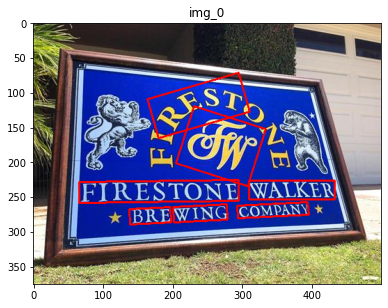

In [25]:
from mindocr.utils.visualize import draw_bboxes, show_imgs

det_vis = draw_bboxes(data['img_path'], det_res['polys'], is_bgr_img=False)
show_imgs([det_vis], is_bgr_img=False)



### Prepare for recogntion

In [26]:
### TODO: modulation

## crop text regions
import cv2

# end2end infer utils
def crop_text_region(img, points, box_type='quad', rotate_if_vertical=True): #polygon_type='poly'):
    # box_type: quad or poly
    def crop_img_box(img, points, rotate_if_vertical=True):
        assert len(points) == 4, "shape of points must be [4, 2]"
        img_crop_width = int(
            max(
                np.linalg.norm(points[0] - points[1]),
                np.linalg.norm(points[2] - points[3])))
        img_crop_height = int(
            max(
                np.linalg.norm(points[0] - points[3]),
                np.linalg.norm(points[1] - points[2])))
        dst_pts = np.float32([[0, 0], [img_crop_width, 0],
                              [img_crop_width, img_crop_height],
                              [0, img_crop_height]])
        #print(points, pts_std)
        trans_matrix = cv2.getPerspectiveTransform(points, dst_pts)
        dst_img = cv2.warpPerspective(
            img,
            trans_matrix, 
            (img_crop_width, img_crop_height),
            borderMode=cv2.BORDER_REPLICATE,
            flags=cv2.INTER_CUBIC)
        
        if rotate_if_vertical:
            h, w = dst_img.shape[0:2]
            if h / float(w) >= 1.5:
                dst_img = np.rot90(dst_img)
            
        return dst_img
    
    if box_type[:4] != 'poly':
        return crop_img_box(img, points, rotate_if_vertical=rotate_if_vertical)
    else: # polygons
        bounding_box = cv2.minAreaRect(np.array(points).astype(np.int32))
        points = sorted(list(cv2.boxPoints(bounding_box)), key=lambda x: x[0])

        index_a, index_b, index_c, index_d = 0, 1, 2, 3
        if points[1][1] > points[0][1]:
            index_a = 0
            index_d = 1
        else:
            index_a = 1
            index_d = 0
        if points[3][1] > points[2][1]:
            index_b = 2
            index_c = 3
        else:
            index_b = 3
            index_c = 2

        box = [points[index_a], points[index_b], points[index_c], points[index_d]]
        crop_img = crop_img_box(img, np.array(box))
        return crop_img
    


0 (22, 59, 3)
1 (22, 77, 3)
2 (18, 102, 3)
3 (30, 229, 3)
4 (27, 123, 3)
5 (86, 108, 3)
6 (58, 136, 3)


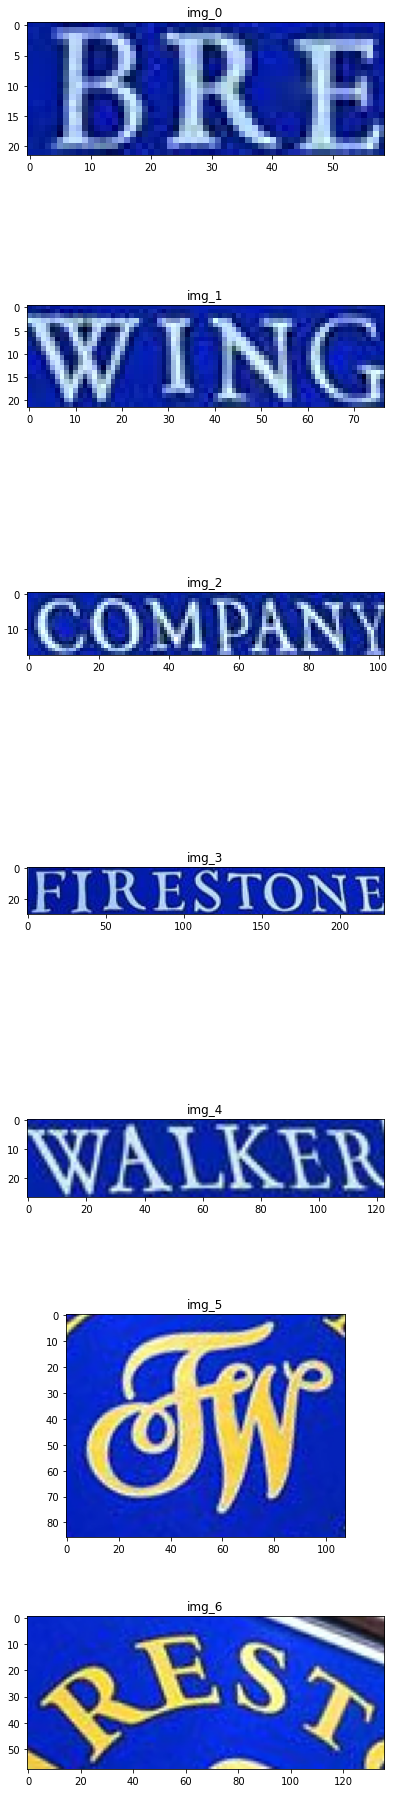

In [27]:
polys = det_res['polys'].copy()
#print(polys)
    
# TODO: modulate?
crops = []
for i in range(len(polys)):
    poly = polys[i].astype(np.float32)
    
    cropped_image = crop_text_region(data['image_ori'], poly, box_type=box_type)
    crops.append(cropped_image)
    print(i, cropped_image.shape)

show_imgs(crops, is_bgr_img=False)

## Recognition

### Preprocess, 

INFO: `character_dict_path` for RecCTCLabelDecode is not given. Default dict "0123456789abcdefghijklmnopqrstuvwxyz" is applied. Only number and English letters (regardless of lower/upper case) will be recognized and evaluated.


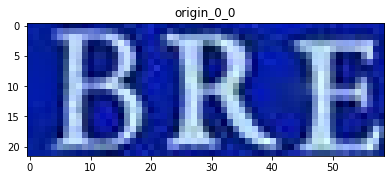

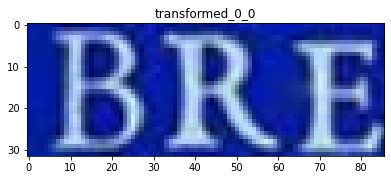

{'texts': 'bre', 'confs': 0.9999289, 'raw_chars': ['<PAD>', '<PAD>', '<PAD>', 'b', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'r', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'e', '<PAD>', '<PAD>', '<PAD>']}


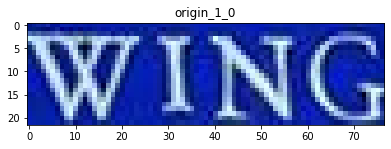

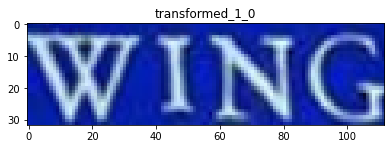

{'texts': 'wing', 'confs': 0.9999968, 'raw_chars': ['<PAD>', '<PAD>', '<PAD>', 'w', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'i', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'n', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'g', '<PAD>', '<PAD>', '<PAD>']}


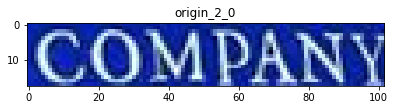

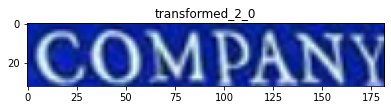

{'texts': 'company', 'confs': 1.0, 'raw_chars': ['<PAD>', '<PAD>', '<PAD>', '<PAD>', 'c', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'o', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'm', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'p', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'a', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'n', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'y', '<PAD>', '<PAD>']}


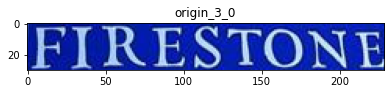

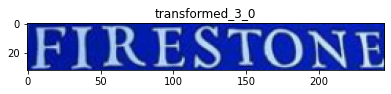

{'texts': 'firestone', 'confs': 0.99999934, 'raw_chars': ['<PAD>', '<PAD>', '<PAD>', 'f', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'i', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'r', 'r', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'e', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 's', 's', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 't', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'o', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'n', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'e', '<PAD>', '<PAD>', '<PAD>']}


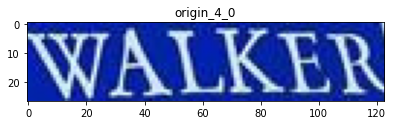

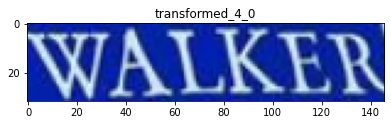

{'texts': 'walker', 'confs': 0.9464163, 'raw_chars': ['<PAD>', '<PAD>', '<PAD>', 'w', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'a', 'a', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'l', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'k', 'k', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'e', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'r', '<PAD>', '<PAD>', '<PAD>']}


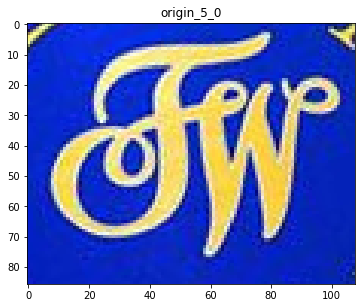

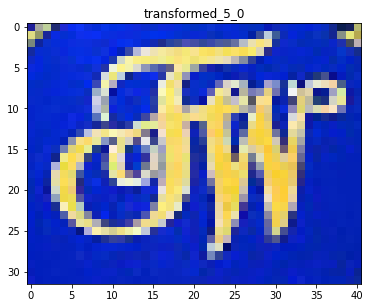

{'texts': 'o', 'confs': 0.38243407, 'raw_chars': ['<PAD>', '<PAD>', '<PAD>', 'o', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']}


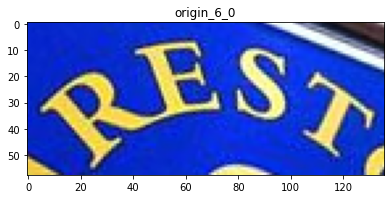

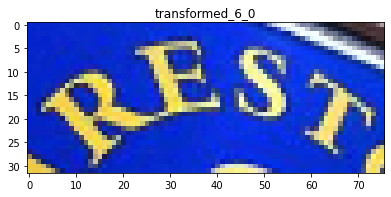

{'texts': 'rest', 'confs': 0.99997497, 'raw_chars': ['<PAD>', '<PAD>', '<PAD>', 'r', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'e', '<PAD>', '<PAD>', '<PAD>', 's', '<PAD>', '<PAD>', '<PAD>', 't', '<PAD>', '<PAD>']}


[{'texts': 'bre',
  'confs': 0.9999289,
  'raw_chars': ['<PAD>',
   '<PAD>',
   '<PAD>',
   'b',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   'r',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   'e',
   '<PAD>',
   '<PAD>',
   '<PAD>']},
 {'texts': 'wing',
  'confs': 0.9999968,
  'raw_chars': ['<PAD>',
   '<PAD>',
   '<PAD>',
   'w',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   'i',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   'n',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   'g',
   '<PAD>',
   '<PAD>',
   '<PAD>']},
 {'texts': 'company',
  'confs': 1.0,
  'raw_chars': ['<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   'c',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   'o',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   'm',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
  

In [28]:
# preprocessor
rec_preproc = Preprocessor(task='rec')
# inferer
rec_inferer = Inferer('crnn_resnet34')
# postprocessor
rec_postproc = Postprocessor('rec', 'crnn')

def text_rec_single(img, visualize_preprocess=False):
    '''
    Args:
        img: str for image path or np.array for image rgb value
    
    Return: 
        dict with keys: 
    '''
    # preprocess
    rec_data = rec_preproc(img)
    
    ## visualize preprocess result
    if visualize_preprocess:
        show_imgs([rec_data['image_ori']], is_bgr_img=False, title=f'origin_{i}')
        show_imgs([rec_data['image']], is_bgr_img=False,  title=f'transformed_{i}',
                  mean_rgb=[127.0, 127.0, 127.0], std_rgb=[127.0, 127.0, 127.0], is_chw=True)

    # infer
    rec_pred = rec_inferer(rec_data['image'])
    #print(rec_pred)
    
    # postprocess
    rec_res = rec_postproc(rec_pred, None)
    
    # squeeze the single output
    for k in rec_res:
        rec_res[k] = rec_res[k][0]
    
    print(rec_res)
    
    return rec_res

visualize_preprocess = True
rec_res_all_crops = []
for i, crop_img in enumerate(crops):
    # infer for each cropped text regions
    rec_res = text_rec_single(crop_img, visualize_preprocess=visualize_preprocess)
    
    rec_res_all_crops.append(rec_res)
    
    if i >= 6:
        break
        
rec_res_all_crops
#title=f'origin_{i}_{det_res['polys'][i]}',
#title=f'transformed_{i}_{det_res['polys'][i]}',
#rec_data

In [33]:
def test_f(a, **kwargs):
    print(kwargs)
    print(kwargs.get('wh', 99))
    
test_f(10, b=3, c=5, wh=44)

{'b': 3, 'c': 5, 'wh': 44}
44


In [29]:
det_res

{'polys': array([[[138., 267.],
         [197., 264.],
         [198., 286.],
         [139., 289.]],
 
        [[201., 264.],
         [278., 260.],
         [279., 282.],
         [202., 286.]],
 
        [[293., 262.],
         [394., 257.],
         [396., 275.],
         [294., 280.]],
 
        [[ 66., 228.],
         [295., 225.],
         [295., 255.],
         [ 66., 258.]],
 
        [[310., 226.],
         [433., 226.],
         [433., 253.],
         [310., 253.]],
 
        [[231., 119.],
         [334., 152.],
         [308., 234.],
         [205., 201.]],
 
        [[164., 109.],
         [295.,  71.],
         [311., 127.],
         [180., 165.]]]),
 'scores': [0.9093689,
  0.84206223,
  0.8992281,
  0.91536385,
  0.90936637,
  0.8012796,
  0.77642864]}

### Merge detection and recogintion for results

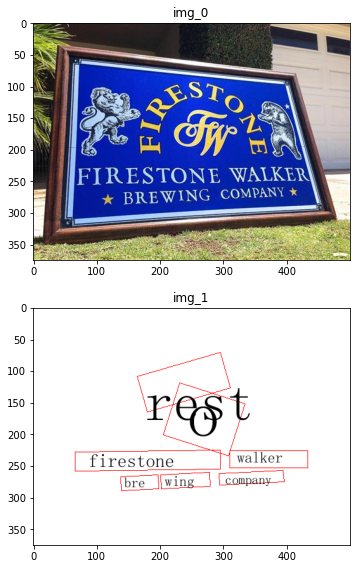

[{'box': array([[138., 267.],
         [197., 264.],
         [198., 286.],
         [139., 289.]]),
  'box_conf': 0.9093689,
  'text': 'bre',
  'text_conf': 0.9999289},
 {'box': array([[201., 264.],
         [278., 260.],
         [279., 282.],
         [202., 286.]]),
  'box_conf': 0.84206223,
  'text': 'wing',
  'text_conf': 0.9999968},
 {'box': array([[293., 262.],
         [394., 257.],
         [396., 275.],
         [294., 280.]]),
  'box_conf': 0.8992281,
  'text': 'company',
  'text_conf': 1.0},
 {'box': array([[ 66., 228.],
         [295., 225.],
         [295., 255.],
         [ 66., 258.]]),
  'box_conf': 0.91536385,
  'text': 'firestone',
  'text_conf': 0.99999934},
 {'box': array([[310., 226.],
         [433., 226.],
         [433., 253.],
         [310., 253.]]),
  'box_conf': 0.90936637,
  'text': 'walker',
  'text_conf': 0.9464163},
 {'box': array([[231., 119.],
         [334., 152.],
         [308., 234.],
         [205., 201.]]),
  'box_conf': 0.8012796,
  'text': 'o

In [30]:
from mindocr.utils.visualize import draw_bboxes_and_texts

def merge_result(det_res, rec_res, data=None, visualize=False):
    '''
    Merge det and rec result for an input image
    
    return:
        list of dict with keys, where each element is the overall result for a detected text region
            - box: np.array, text box for points, shape [num_points, 2], num_points is dynamic.
            - box_conf: float, confidence of the detected text box
            - text: str, text
            - text_conf: float, confidence of the recognized text
    '''
    res = []
    num_text_regions = len(det_res['polys'])
    for i in range(num_text_regions):
        box = det_res['polys'][i]
        box_conf = det_res['scores'][i]
        
        text = rec_res[i]['texts']
        text_conf = rec_res[i]['confs']
        
        region_res = dict(box=box, box_conf=box_conf, text=text, text_conf=text_conf)
            
        res.append(region_res)
        
    if visualize:
        img_shape = data['shape'][:2]
        blank_img = np.ones([img_shape[0], img_shape[1], 3], dtype=np.uint8) * 255
        
        #vis_img = draw_bboxes(blank_img, det_res['polys'])
        texts = [rec_res[i]['texts'] for i in range(num_text_regions)]
        vis_img = draw_bboxes_and_texts(blank_img, det_res['polys'], texts, 
                                        font_path='mindocr/utils/font/simfang.ttf',
                                        font_size=None,
                                        is_bgr_img=False,
                                        hide_boxes=False,
                                        text_inside_box=True)
        
        show_imgs([data['image_ori'], vis_img], is_bgr_img=False)
        
    return res

overall_res = merge_result(det_res, rec_res_all_crops, data=data, visualize=True)
overall_res

In [31]:
from mindocr import list_models
list_models()

['crnn_resnet34',
 'crnn_vgg7',
 'dbnet_mobilenetv3',
 'dbnet_resnet18',
 'dbnet_resnet50',
 'dbnetpp_resnet50',
 'rare_resnet34']

### Data preparation - Method 1: reuse/modify data processing pipeline from examplar yaml config

src_config_fp = 'configs/det/dbnet/db++_r50_icdar15.yaml'
label_fp = '/Users/Samit/Data/datasets/ic15/det/test/det_gt.txt'

from tools.predict.text.utils_predict import load_yaml  #TODO: don't put here

cfg = load_yaml(src_config_fp)

# update data_dir, 
cfg.eval.dataset.data_dir = data_dir
cfg.eval.dataset.dataset_root = ''
if label_fp is not None:
    cfg.eval.dataset.label_file = label_fp # TODO: 
    cfg.eval.dataset.output_columns.append('img_path')
    
else:
    poped = cfg.eval.dataset.transform_pipeline.pop(1)
    cfg.eval.dataset.output_columns = ['image', 'image_path']
    cfg.eval.dataset.pop('net_input_column_index')
    cfg.eval.dataset.pop('label_column_index')
    cfg.eval.dataset.pop('label_file')
cfg.eval.dataset

ds = build_dataset(cfg.eval.dataset, cfg.eval.loader, is_train=False)


iterator = ds.create_dict_iterator(num_epochs=1)

for i, item in enumerate(iterator):
    print(i, item['img_path'])
    if i >= 10:
        break

### Data preparation - Method 2: predefined data pipeline from transform factory

```python
build_dataset('dbnetpp_resnet50_infer', data_dir=data_dir, batch_size=, num_workers)
```

##  CLI Infer

!python tools/predict/text/predict_system.py  --



* Code Structure and API Guideline
    - mindocr
        - [dataset](mindocr/data/README.md)
        - [model](mindocr/models/README.md)
        - postprocess
        - metric
    - tools
        - Python online infer script
        - 
    - deploy
